## Each algorithm

--- Analyzing: CEGAR with Predicative Abstracion ---


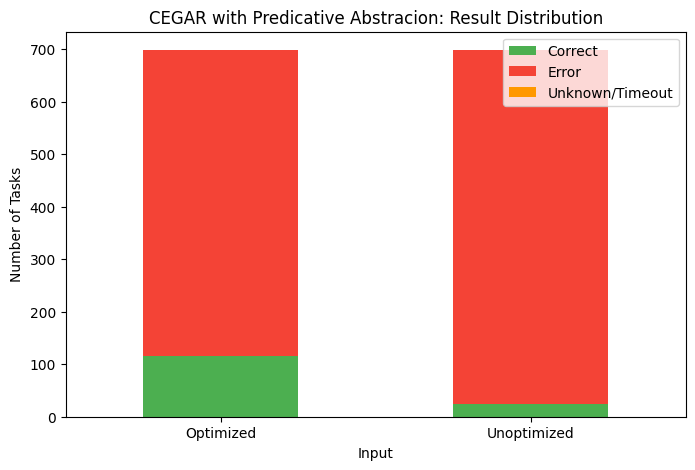

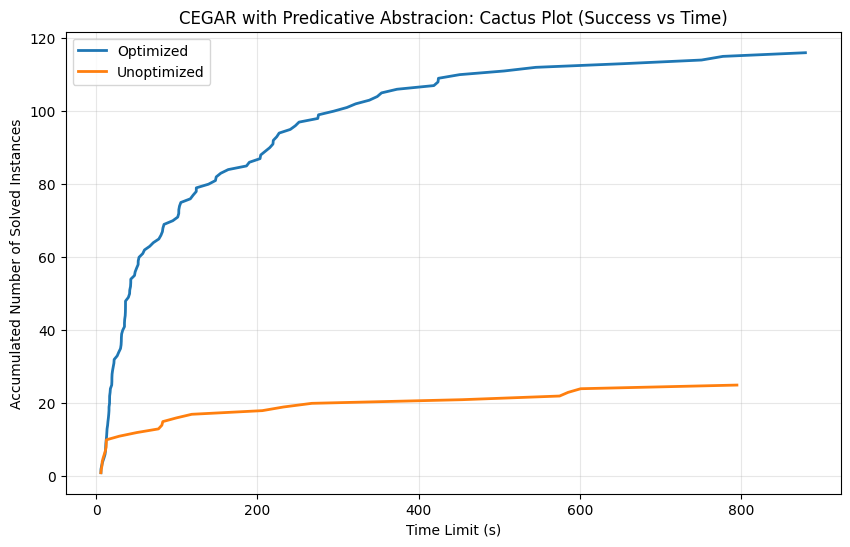

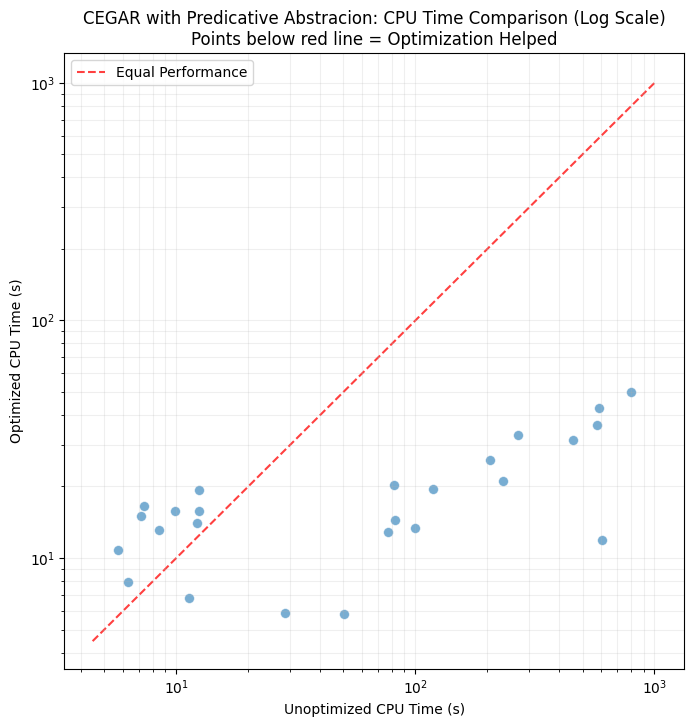



--- Analyzing: CEGAR with Explicit-Value based Abstracion ---


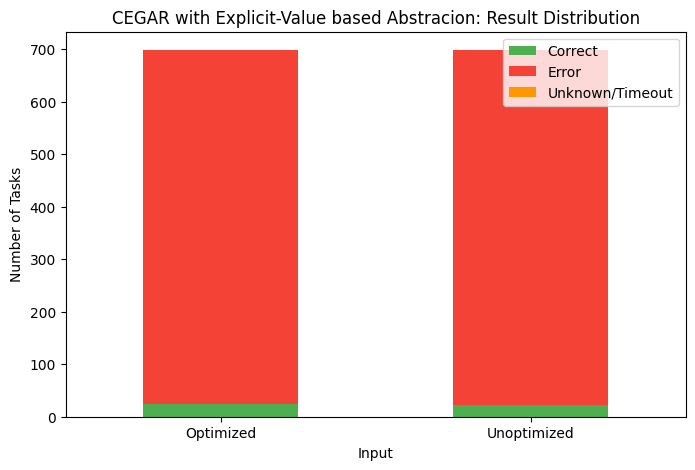

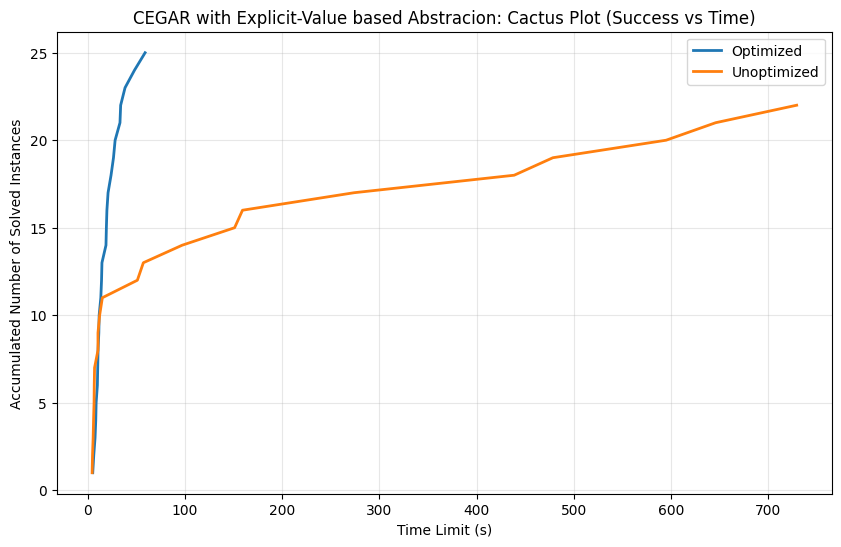

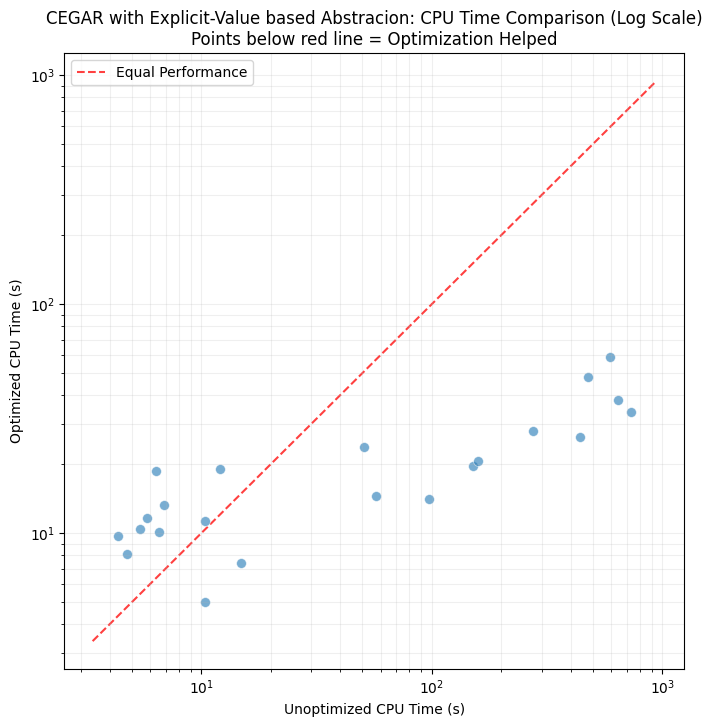



--- Analyzing: BMC ---


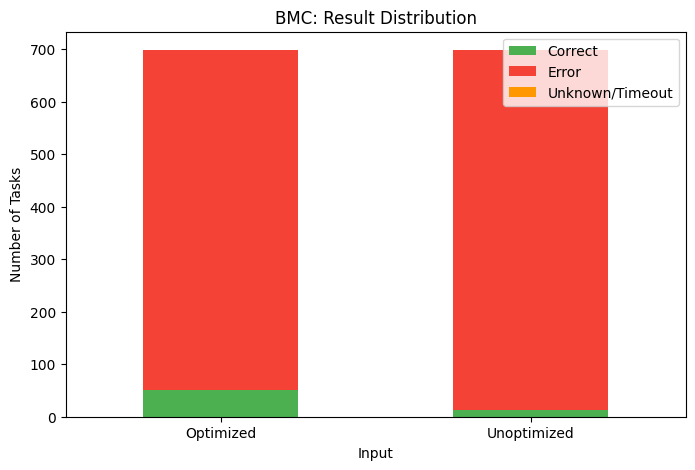

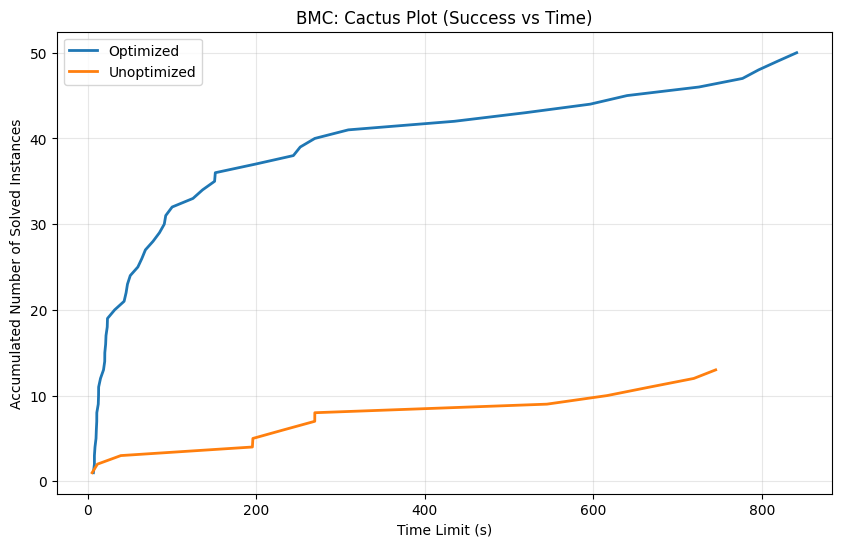

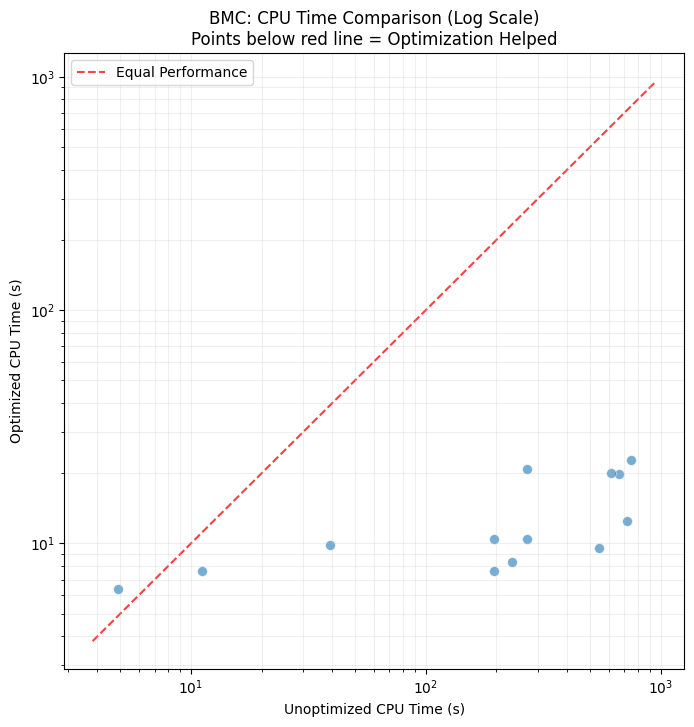



--- Analyzing: IMC ---


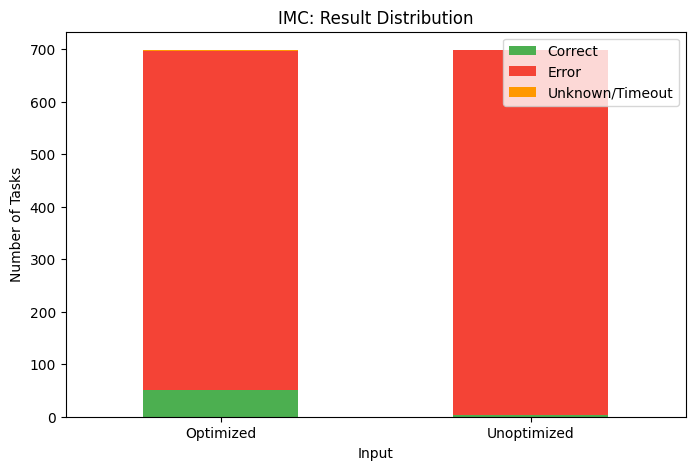

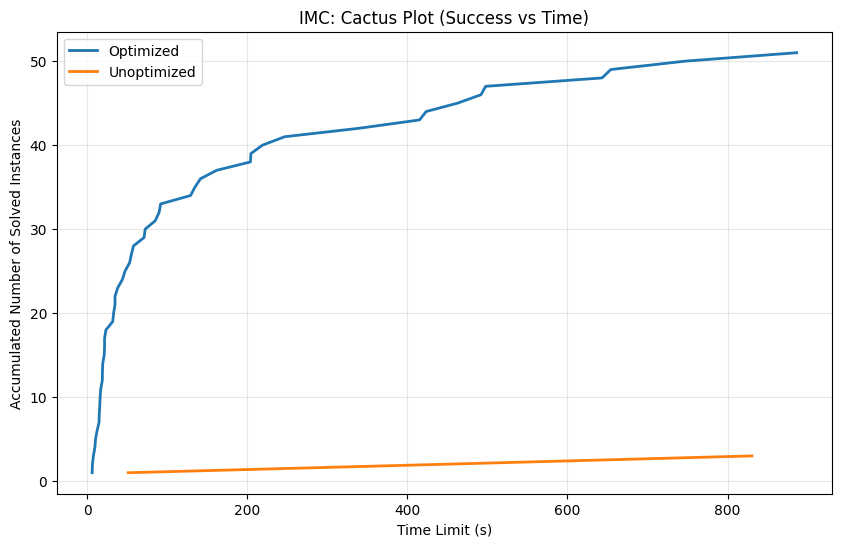

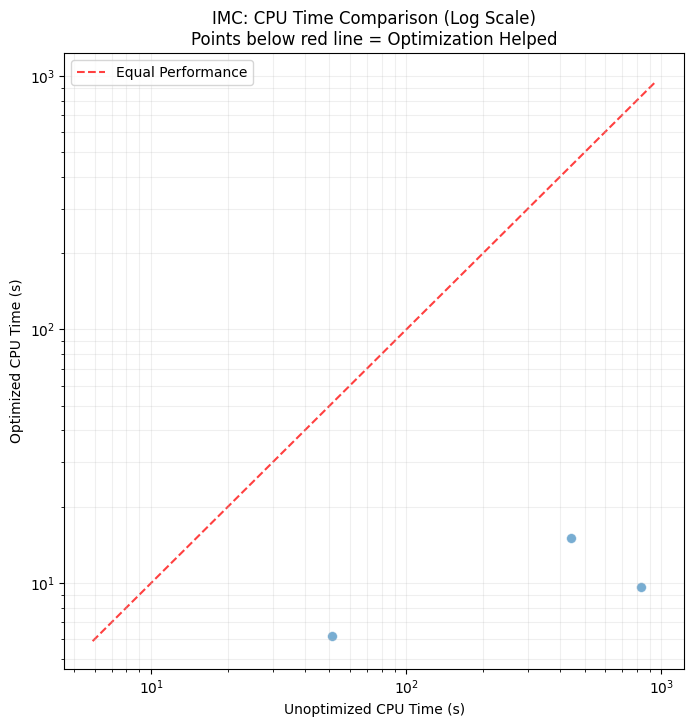



--- Analyzing: K-Induction ---


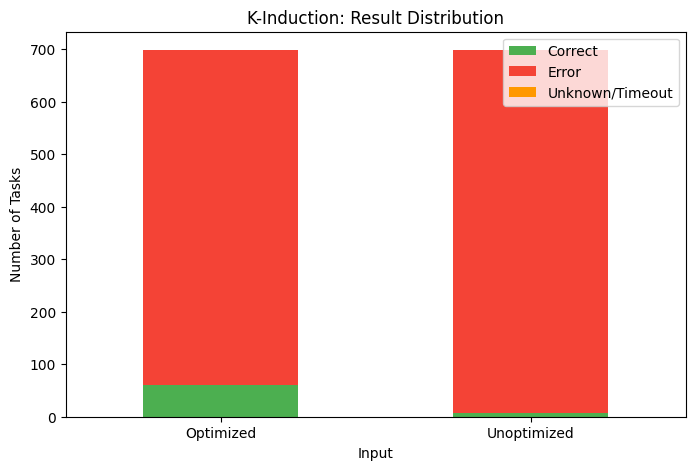

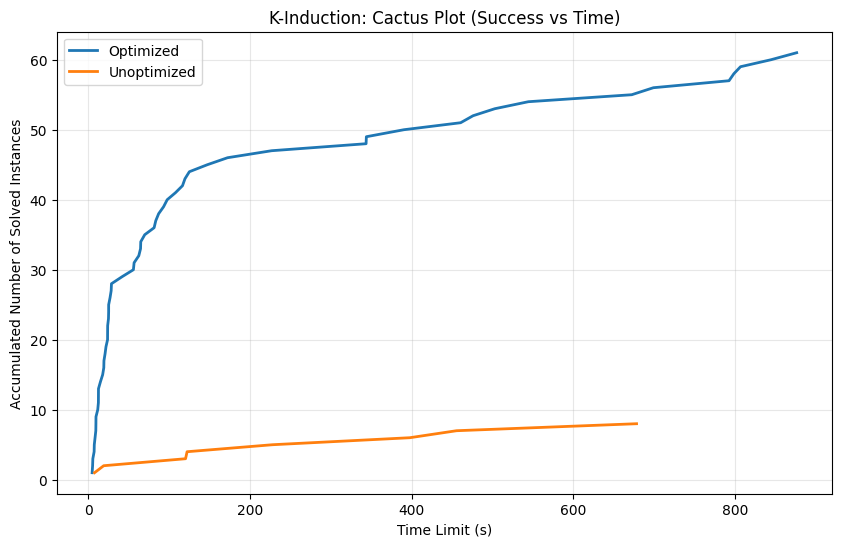

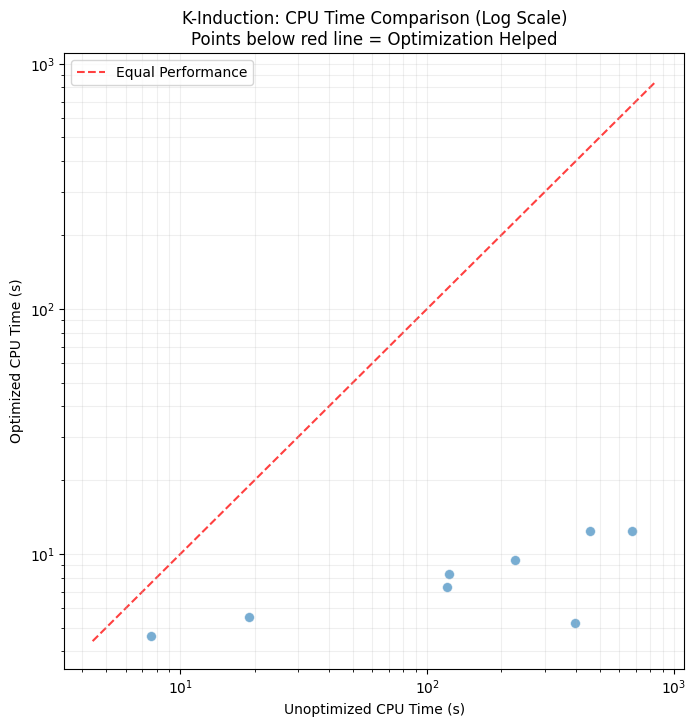

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DATA_FOLDER = "result_xmls_btor2"

# Format: ("Algorithm", "Optimized File", "Unoptimized File")
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-pred-cegar.btor2-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-expl-cegar.btor2-expl.xml")),
    ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-bounded.btor2.xml")),
    ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-imc.btor2.xml")),
    ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-kind.btor2.xml")),
]

# --- 1. XML Parsing Function ---
def parse_benchexec_xml(filepath):
    """Parses BenchExec XML and returns a DataFrame with clean types."""
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None

    tree = ET.parse(filepath)
    root = tree.getroot()
    
    data = []
    
    for run in root.findall('.//run'):
        file_name = run.get('name')
        cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
        
        status = cols.get('status', run.get('status'))
        category = cols.get('category', run.get('category'))
        
        # Clean CPU Time
        cpu_time = cols.get('cputime', 'nan')
        if isinstance(cpu_time, str):
            cpu_time = float(cpu_time.replace('s', ''))
            
        # Clean Memory
        memory = cols.get('memory', 'nan')
        if isinstance(memory, str):
            memory = float(memory.replace('B', '')) / (1024 * 1024) # MB

        # Normalize Name
        base_name = os.path.splitext(os.path.basename(file_name))[0]

        data.append({
            'base_name': base_name,
            'full_name': file_name,
            'status': status,
            'category': category,
            'cputime': cpu_time,
            'memory_mb': memory
        })
        
    return pd.DataFrame(data)

# --- 2. Visualization Functions ---

def plot_cpu_scatter(df, algo_name):
    """Scatter plot: Unoptimized (x) vs Optimized (y)"""
    plt.figure(figsize=(8, 8))
    
    # Filter only where both solved correctly
    correct_df = df[(df['category_opt'] == 'correct') & (df['category_no_opt'] == 'correct')]
    
    plt.xscale('log')
    plt.yscale('log')
    
    # x = Unoptimized, y = Optimized
    sns.scatterplot(data=correct_df, x='cputime_no_opt', y='cputime_opt', alpha=0.6, s=50)
    
    # Diagonal line
    lims = [
        min(plt.xlim()[0], plt.ylim()[0]), 
        max(plt.xlim()[1], plt.ylim()[1])
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Equal Performance')
    
    plt.title(f"{algo_name}: CPU Time Comparison (Log Scale)\nPoints below red line = Optimization Helped")
    plt.xlabel("Unoptimized CPU Time (s)")
    plt.ylabel("Optimized CPU Time (s)")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

def plot_cactus(df_opt, df_no_opt, algo_name):
    """Cactus plot: Sorted time vs Number of solved instances"""
    plt.figure(figsize=(10, 6))
    
    for label, data in [('Optimized', df_opt), ('Unoptimized', df_no_opt)]:
        solved = data[data['category'] == 'correct']['cputime'].sort_values().reset_index(drop=True)
        plt.plot(solved, solved.index + 1, label=label, linewidth=2)
        
    plt.title(f"{algo_name}: Cactus Plot (Success vs Time)")
    plt.xlabel("Time Limit (s)")
    plt.ylabel("Accumulated Number of Solved Instances")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_status_bars(df_opt, df_no_opt, algo_name):
    """Compare success/fail counts"""
    def get_counts(df, label):
        counts = df['category'].value_counts()
        return {
            'Input': label,
            'Correct': counts.get('correct', 0),
            'Error': counts.get('error', 0),
            # Uncommented this to show full picture (timeouts/unknowns)
            'Unknown/Timeout': len(df) - counts.get('correct', 0) - counts.get('error', 0) 
        }

    stats = pd.DataFrame([get_counts(df_opt, 'Optimized'), get_counts(df_no_opt, 'Unoptimized')])
    
    # Plotting
    # Colors: Green (Correct), Red (Error), Orange (Timeout)
    stats.set_index('Input').plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336', '#FF9800'], figsize=(8, 5))
    plt.title(f"{algo_name}: Result Distribution")
    plt.ylabel("Number of Tasks")
    plt.xticks(rotation=0)
    plt.show()

# --- 3. Main Execution Loop ---

for algo_name, opt_file, no_opt_file in PAIRS:
    print(f"--- Analyzing: {algo_name} ---")
    
    df_opt = parse_benchexec_xml(opt_file)
    df_no_opt = parse_benchexec_xml(no_opt_file)
    
    if df_opt is not None and df_no_opt is not None:
        # Merge for direct comparison
        # Suffixes: _opt vs _no_opt
        merged_df = pd.merge(
            df_opt, 
            df_no_opt, 
            on='base_name', 
            how='inner', 
            suffixes=('_opt', '_no_opt')
        )
        
        # 1. Status Bar Chart
        plot_status_bars(df_opt, df_no_opt, algo_name)
        
        # 2. Cactus Plot
        plot_cactus(df_opt, df_no_opt, algo_name)
        
        # 3. Scatter Plot
        if len(merged_df) > 0:
            plot_cpu_scatter(merged_df, algo_name)
        else:
            print("No matching benchmark names found (check file naming conventions).")
            
    print("\n" + "="*50 + "\n")

## All Algos

Processing files...

--- Summary Comparison Table ---


Configuration                                     Optimized                  \
                                           Avg CPU Time (s) Avg Memory (MB)   
Algorithm                                                                     
BMC                                                  182.13          696.40   
CEGAR with Explicit-Value based Abstracion            19.92          480.98   
CEGAR with Predicative Abstracion                    134.67         1717.04   
IMC                                                  159.21         1060.91   
K-Induction                                          178.39          777.55   

Configuration                                                    Unoptimized  \
                                           Success Rate (%) Avg CPU Time (s)   
Algorithm                                                                      
BMC                                                    7.16           346.93   
CEGAR with Explicit-Value based Abstracion             3.58           171.13   
CEGAR with Predicative Abstracion                     16.62           173.86   
IMC                                                    7.31           441.54   
K-Induction                                            8.74           253.51   

Configuration                                                                
                                           Avg Memory (MB) Success Rate (%)  
Algorithm                                                                    
BMC                                                6466.49             1.86  
CEGAR with Explicit-Value based Abstracion          610.08             3.15  
CEGAR with Predicative Abstracion                   831.74             3.58  
IMC                                                8706.09             0.43  
K-Induction                                        3238.74             1.15

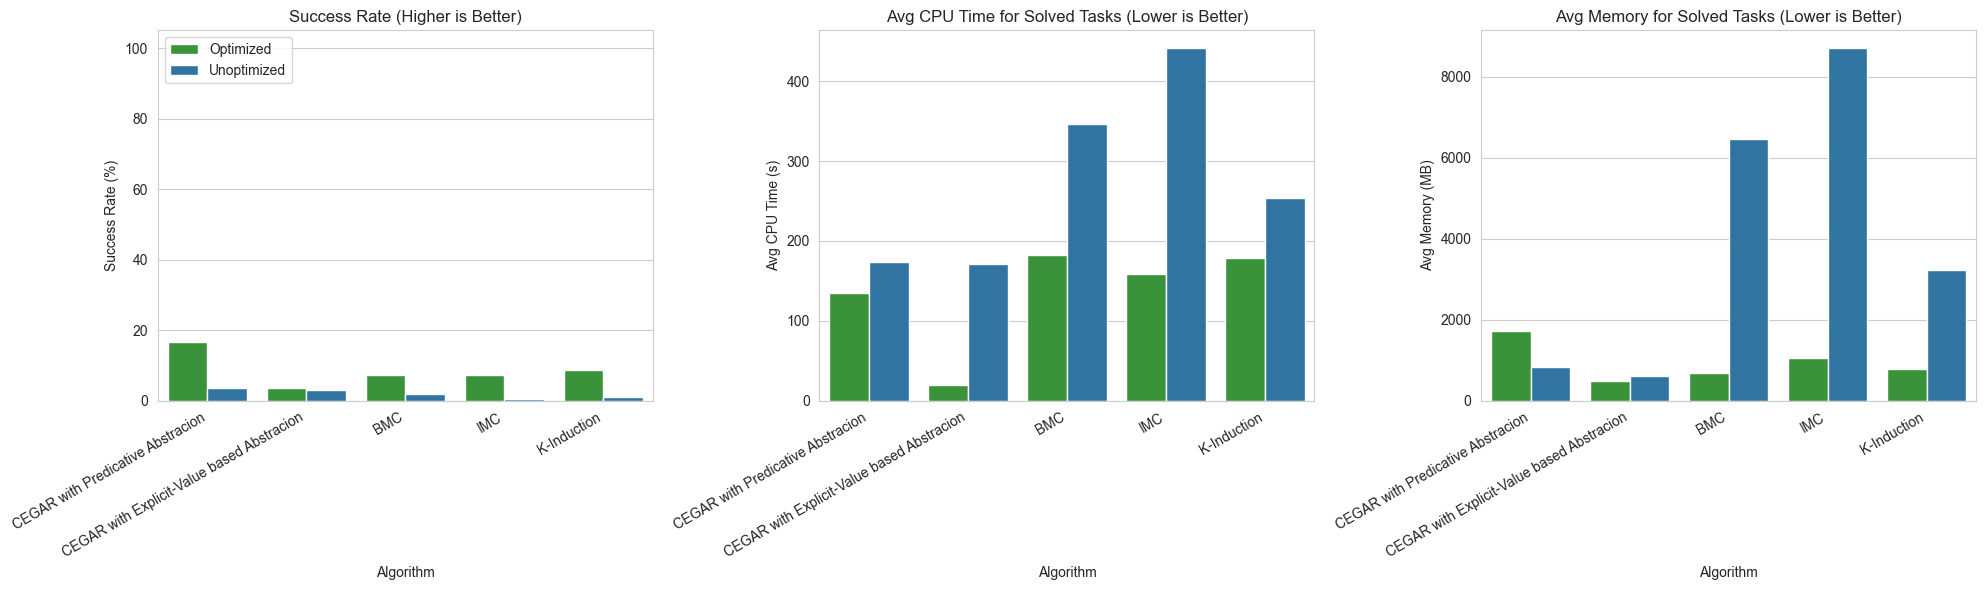

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DATA_FOLDER = "result_xmls_btor2"

# Format: ("Algorithm", "Optimized File", "Unoptimized File")
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-pred-cegar.btor2-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-expl-cegar.btor2-expl.xml")),
     ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-bounded.btor2.xml")),
     ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-imc.btor2.xml")),
     ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-kind.btor2.xml")),
]

# --- Helper Function to Extract Aggregated Stats ---
def get_file_stats(filepath):
    """
    Parses a single XML file and calculates:
    - Success Rate (%)
    - Avg CPU Time (s) [for correct runs only]
    - Avg Memory (MB) [for correct runs only]
    """
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None

    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        
        cputimes = []
        memories = []
        total_count = 0
        success_count = 0
        
        for run in root.findall('.//run'):
            total_count += 1
            
            # Extract columns
            cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
            
            # Check status (supports 'category' attribute or column)
            category = cols.get('category', run.get('category'))
            
            if category == 'correct':
                success_count += 1
                
                # Parse CPU Time
                t_str = cols.get('cputime', '0s')
                if t_str.endswith('s'):
                    cputimes.append(float(t_str.replace('s', '')))
                
                # Parse Memory
                m_str = cols.get('memory', '0B')
                if m_str.endswith('B'):
                    memories.append(float(m_str.replace('B', '')) / (1024 * 1024)) # Convert to MB

        # Calculate Averages
        success_rate = (success_count / total_count * 100) if total_count > 0 else 0
        avg_cpu = sum(cputimes) / len(cputimes) if cputimes else 0
        avg_mem = sum(memories) / len(memories) if memories else 0
        
        return success_rate, avg_cpu, avg_mem

    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        return None

# --- Main Logic ---
summary_data = []

print("Processing files...")
for algo_name, opt_file, no_opt_file in PAIRS:
    
    # 1. Process Optimized File
    stats_opt = get_file_stats(opt_file)
    if stats_opt:
        summary_data.append({
            'Algorithm': algo_name,
            'Configuration': 'Optimized',
            'Success Rate (%)': stats_opt[0],
            'Avg CPU Time (s)': stats_opt[1],
            'Avg Memory (MB)': stats_opt[2]
        })
        
    # 2. Process Unoptimized File
    stats_no_opt = get_file_stats(no_opt_file)
    if stats_no_opt:
        summary_data.append({
            'Algorithm': algo_name,
            'Configuration': 'Unoptimized',
            'Success Rate (%)': stats_no_opt[0],
            'Avg CPU Time (s)': stats_no_opt[1],
            'Avg Memory (MB)': stats_no_opt[2]
        })

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

# --- Summary Table ---
if not df_summary.empty:
    print("\n--- Summary Comparison Table ---")
    # Pivot for clean comparison
    df_pivot = df_summary.pivot(index='Algorithm', columns='Configuration')
    # Reorder to keep metrics grouped
    df_pivot = df_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)
    
    # Optional: Sort columns to ensure Optimized comes before Unoptimized if desired, 
    # but alphabetical usually works fine.
    display(df_pivot.round(2))

    # --- Visualizations ---
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Define Palette (Green for Optimized, Gray/Blue for Unoptimized)
    custom_palette = {"Optimized": "#2ca02c", "Unoptimized": "#1f77b4"}
    
    # 1. Success Rate
    sns.barplot(data=df_summary, x='Algorithm', y='Success Rate (%)', hue='Configuration', ax=axes[0], palette=custom_palette)
    axes[0].set_title('Success Rate (Higher is Better)')
    axes[0].set_ylim(0, 105)
    axes[0].legend(loc='upper left')
    
    # 2. CPU Time
    sns.barplot(data=df_summary, x='Algorithm', y='Avg CPU Time (s)', hue='Configuration', ax=axes[1], palette=custom_palette)
    axes[1].set_title('Avg CPU Time for Solved Tasks (Lower is Better)')
    axes[1].get_legend().remove()
    
    # 3. Memory
    sns.barplot(data=df_summary, x='Algorithm', y='Avg Memory (MB)', hue='Configuration', ax=axes[2], palette=custom_palette)
    axes[2].set_title('Avg Memory for Solved Tasks (Lower is Better)')
    axes[2].get_legend().remove()
    
    # Formatting
    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
    plt.tight_layout()
    plt.show()
else:
    print("No data extracted. Please check file paths and ensure the 'result_xmls_btor2' folder exists.")

## timeout and out of memory rates

Processing files for failure analysis...


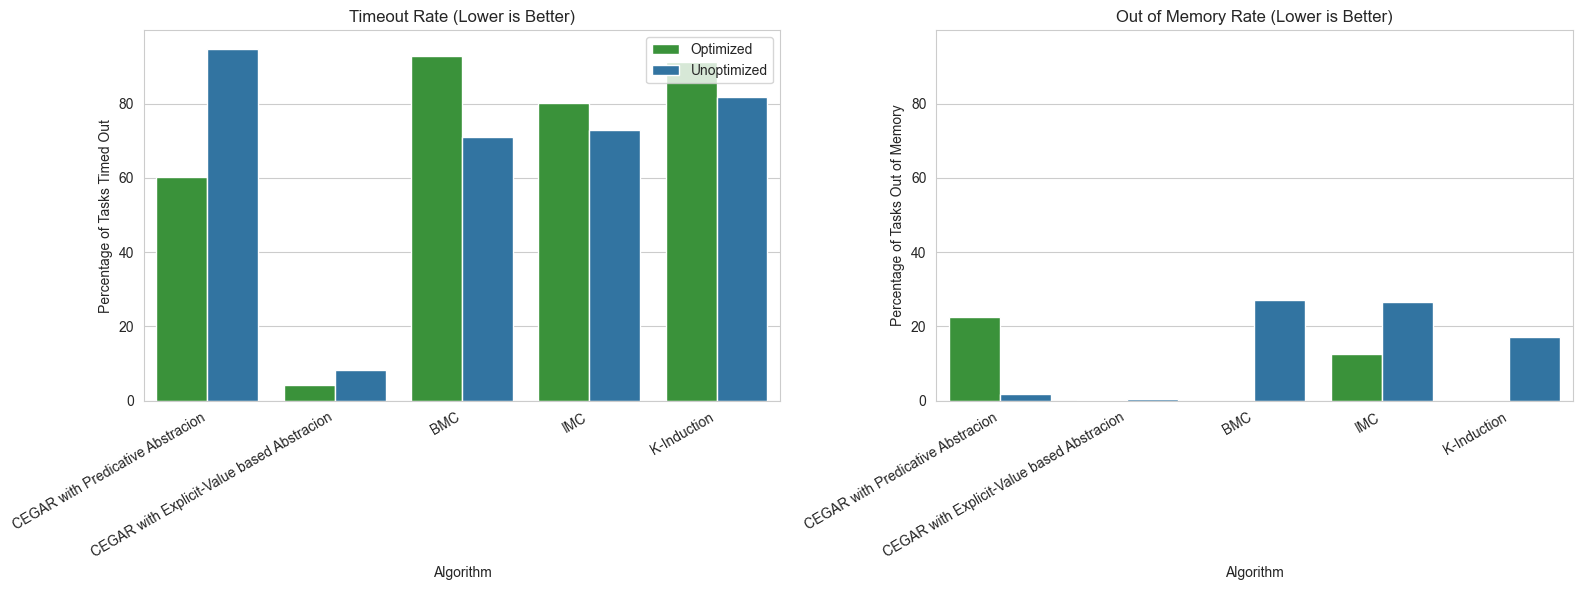


--- Failure Rates Summary ---


Configuration                                 Optimized                   \
                                           OOM Rate (%) Timeout Rate (%)   
Algorithm                                                                  
BMC                                                0.00            92.84   
CEGAR with Explicit-Value based Abstracion         0.14             4.15   
CEGAR with Predicative Abstracion                 22.64            60.32   
IMC                                               12.46            80.09   
K-Induction                                        0.00            91.26   

Configuration                               Unoptimized                   
                                           OOM Rate (%) Timeout Rate (%)  
Algorithm                                                                 
BMC                                               27.08            71.06  
CEGAR with Explicit-Value based Abstracion         0.57             8.31  
CEGAR with Predicative Abstracion                  1.72            94.70  
IMC                                               26.50            72.78  
K-Induction                                       17.05            81.81

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DATA_FOLDER = "result_xmls_btor2"

# Format: ("Algorithm", "Optimized File", "Unoptimized File")
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-pred-cegar.btor2-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-expl-cegar.btor2-expl.xml")),
     ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-bounded.btor2.xml")),
     ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-imc.btor2.xml")),
     ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-kind.btor2.xml")),
]

# --- Helper Function ---
def get_failure_stats(filepath):
    """
    Parses an XML file to calculate Timeout and Out of Memory (OOM) rates.
    """
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None

    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        
        total_count = 0
        timeout_count = 0
        oom_count = 0
        
        for run in root.findall('.//run'):
            total_count += 1
            
            # Get status string (e.g., "TIMEOUT (900s)", "OUT OF MEMORY")
            cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
            status = cols.get('status', run.get('status', '')).upper()
            
            if 'TIMEOUT' in status:
                timeout_count += 1
            elif 'OUT OF MEMORY' in status:
                oom_count += 1
                
        # Calculate Rates
        timeout_rate = (timeout_count / total_count * 100) if total_count > 0 else 0
        oom_rate = (oom_count / total_count * 100) if total_count > 0 else 0
        
        return timeout_rate, oom_rate

    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        return None

# --- Main Logic ---
failure_data = []

print("Processing files for failure analysis...")
for algo_name, opt_file, no_opt_file in PAIRS:
    
    # 1. Optimized Stats
    stats_opt = get_failure_stats(opt_file)
    if stats_opt:
        failure_data.append({
            'Algorithm': algo_name,
            'Configuration': 'Optimized',
            'Timeout Rate (%)': stats_opt[0],
            'OOM Rate (%)': stats_opt[1]
        })
        
    # 2. Unoptimized Stats
    stats_no_opt = get_failure_stats(no_opt_file)
    if stats_no_opt:
        failure_data.append({
            'Algorithm': algo_name,
            'Configuration': 'Unoptimized',
            'Timeout Rate (%)': stats_no_opt[0],
            'OOM Rate (%)': stats_no_opt[1]
        })

# Create DataFrame
df_fail = pd.DataFrame(failure_data)

# --- Visualization ---
if not df_fail.empty:
    sns.set_style("whitegrid")
    
    # Create 2 subplots (one for Timeout, one for OOM)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Palette: Green for Optimized, Blue/Gray for Unoptimized
    custom_palette = {"Optimized": "#2ca02c", "Unoptimized": "#1f77b4"}
    
    # 1. Timeout Rate Plot
    sns.barplot(data=df_fail, x='Algorithm', y='Timeout Rate (%)', hue='Configuration', ax=axes[0], palette=custom_palette)
    axes[0].set_title('Timeout Rate (Lower is Better)')
    axes[0].set_ylabel('Percentage of Tasks Timed Out')
    axes[0].legend(loc='upper right')
    
    # 2. OOM Rate Plot
    sns.barplot(data=df_fail, x='Algorithm', y='OOM Rate (%)', hue='Configuration', ax=axes[1], palette=custom_palette)
    axes[1].set_title('Out of Memory Rate (Lower is Better)')
    axes[1].set_ylabel('Percentage of Tasks Out of Memory')
    axes[1].get_legend().remove()
    
    # Formatting Labels
    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        # Dynamic Y-limit with a small buffer
        max_val = max(df_fail['Timeout Rate (%)'].max(), df_fail['OOM Rate (%)'].max())
        ax.set_ylim(0, max_val + 5)

    plt.tight_layout()
    plt.show()
    
    # --- Summary Table ---
    print("\n--- Failure Rates Summary ---")
    df_pivot = df_fail.pivot(index='Algorithm', columns='Configuration')
    df_pivot = df_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)
    display(df_pivot.round(2))
else:
    print("No data processed. Check file paths.")